In [1]:
from ssht_heatnet import HeatNet
from ssht_datageneration import generate_domain_points, generate_boundary_points
from ssht_loss_fns import pde_loss_2d, bc_loss_2d

import torch
import numpy as np
import matplotlib.pyplot as plt

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using {device}")

if device.type == 'cpu':
    torch.set_num_threads(16)
    print(f"Limiting cpu threads to: {torch.get_num_threads()}")

Using cpu
Limiting cpu threads to: 16


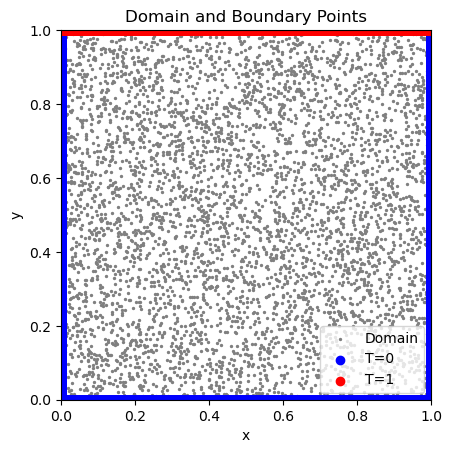

In [2]:
# generating specific training data

n_domain = 5000
n_bc = 2500
x_domain, y_domain = generate_domain_points(n_domain)
x_bc, y_bc, t_bc = generate_boundary_points(n_bc)

plt.scatter(x_domain, y_domain, c='gray', s=2, label='Domain')
plt.scatter(x_bc[t_bc==0], y_bc[t_bc==0], c='b', label='T=0')
plt.scatter(x_bc[t_bc==1], y_bc[t_bc==1], c='r', label='T=1')

plt.xlabel('x')
plt.ylabel('y')
plt.title('Domain and Boundary Points')
plt.legend()
plt.axis('square')
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.show()

In [3]:
#instantiate the model

model = HeatNet(
    input_dim=2, output_dim=1, n_units=60, epochs=700, lr=0.001,
    pde_loss=pde_loss_2d, bc_loss=bc_loss_2d, pde_weight=1.0, bc_weight=100.0,
    use_ffe=False, #num_frequencies=16, fourier_scale=1
)

Epoch 0: Loss (tot) 38.183, Loss (pde) 0.00011980041017523035, Loss (bc) 38.18282699584961 
Epoch 30: Loss (tot) 9.970, Loss (pde) 0.1585593968629837, Loss (bc) 9.811225891113281 
Epoch 60: Loss (tot) 9.481, Loss (pde) 0.08778175711631775, Loss (bc) 9.392847061157227 
Epoch 90: Loss (tot) 9.080, Loss (pde) 0.06104002147912979, Loss (bc) 9.018562316894531 
Epoch 120: Loss (tot) 8.450, Loss (pde) 0.06309621781110764, Loss (bc) 8.386954307556152 
Epoch 150: Loss (tot) 6.646, Loss (pde) 0.10998965799808502, Loss (bc) 6.5355448722839355 
Epoch 180: Loss (tot) 4.319, Loss (pde) 0.5977634787559509, Loss (bc) 3.720890998840332 
Epoch 210: Loss (tot) 3.929, Loss (pde) 0.3369845449924469, Loss (bc) 3.5918943881988525 
Epoch 240: Loss (tot) 3.553, Loss (pde) 0.28261861205101013, Loss (bc) 3.2700858116149902 
Epoch 270: Loss (tot) 3.156, Loss (pde) 0.2228580117225647, Loss (bc) 2.933136463165283 


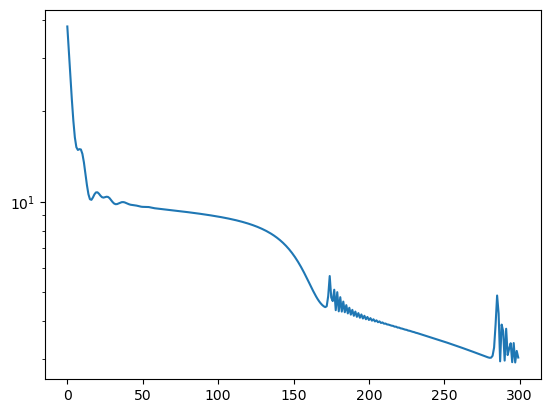

In [4]:
#losses calculation


losses = model.fit(x_domain, y_domain, x_bc, y_bc, t_bc)

plt.plot(losses)
plt.yscale('log')

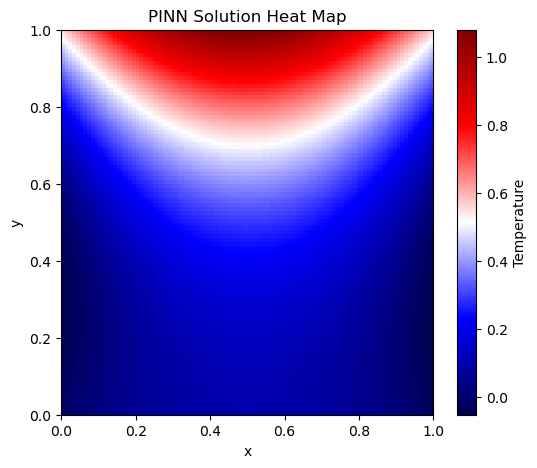

In [5]:
# now using the pinn, trained on random data, to estimate the solution to the heat equation everywhere
# in the grid, ie giving a heat map


# Create a regular grid
n = 100
x = np.linspace(0, 1, n)
y = np.linspace(0, 1, n)
X, Y = np.meshgrid(x, y)
x_flat = X.flatten()
y_flat = Y.flatten()


# Predict on the grid
xy = torch.tensor(np.stack([x_flat, y_flat], axis=1), dtype=torch.float32)
with torch.no_grad():
    T_pred = model(xy).cpu().numpy().reshape(n, n)


# Plot heatmap
plt.figure(figsize=(6,5))
plt.imshow(T_pred, extent=[0,1,0,1], origin='lower', aspect='auto', cmap='seismic')
plt.colorbar(label='Temperature')
plt.xlabel('x')
plt.ylabel('y')
plt.title('PINN Solution Heat Map')
plt.show()

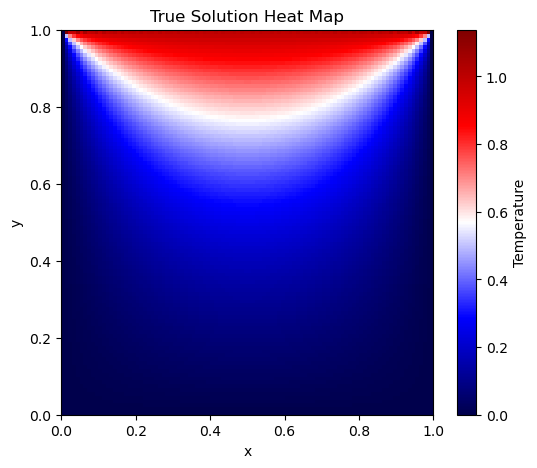

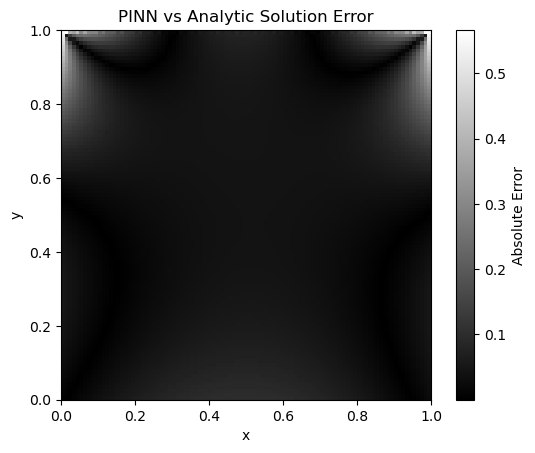

In [6]:
# Now to see a heatmap of the error (analytic solution - PINNs predictions)

def analytic_solution(x, y, terms = 40):

    T = np.zeros_like(x)
    for n in range(1, 2*terms, 2):  # odd n only
        coef = (4 / (n * np.pi))
        numerator = np.sinh(n * np.pi * y)
        denominator = np.sinh(n * np.pi)
        T += coef * (numerator / denominator) * np.sin(n * np.pi * x)
    return T
    
    
T_true_grid = analytic_solution(X, Y)
error_grid = np.abs(T_pred - T_true_grid)

plt.figure(figsize=(6,5))
plt.imshow(T_true_grid, extent=[0,1,0,1], origin='lower', aspect='auto', cmap='seismic')
plt.colorbar(label='Temperature')
plt.xlabel('x')
plt.ylabel('y')
plt.title('True Solution Heat Map')
plt.show()

plt.imshow(error_grid, extent=[0,1,0,1], origin='lower', cmap='gray')
# extent=[xmin, xmax, ymin, ymax] ;  imshow puts origin top left so 'lower' moves it to bottom left
plt.colorbar(label='Absolute Error')
plt.xlabel('x')
plt.ylabel('y')
plt.title('PINN vs Analytic Solution Error')
plt.show()